# msld_py_prep Tutorial for Streamlined MS$\lambda$D Small Molecule Setup

### This tutorial assumes that you are working within a Conda environment that already has pyCHARMM installed and that you have the following tools already loaded in your session:
- ParamChem (CGenFF module)
- MMTSB 

## The problem we are trying to solve: 
Find a set of common core atoms within a molecule series that have matching atom types, connectivity, and partial atomic charges. This is a necessary requirement for the current implementation of MSLD in CHARMM, where we fragment molecules into a `common core` and the respective alchemical substituents at each perturbation site. This creates a hybrid multiple topology model.

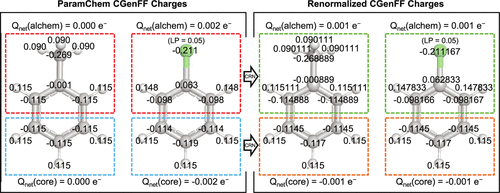

While atom type connectivity can be readily identified with a Maximum Common Substructure (MCS) search (as we do here), the partial charges of common atoms across similar molecules often differ. Thus, we perform charge renormalization to ensure common core atoms have consisten atomic charges across all molecules and that each alchemical substituent has a consistent net charge, as shown in the figure above.

### The diagram below shows the typical workflow of the msld_py_prep scripts to solve the main problem described above.

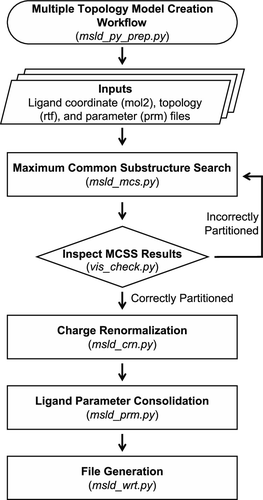

#### "Optimizing Multisite λ-Dynamics Throughput with Charge Renormalization" Jonah Z. Vilseck, Luis F. Cervantes, Ryan L. Hayes, and Charles L. Brooks Journal of Chemical Information and Modeling 2022 62 (6), 1479-1488; DOI: 10.1021/acs.jcim.2c00047

## I. Set Up Dependencies

We need to make sure we have the msld_py_prep scripts cloned, RDKit installed, PyMOL set up, and that we have a ParamChem module installed and aliased as 'cgenff' ready to use on the terminal

In [ ]:
import os
# Install RDKit, pyMOL and pandas to your conda environment if you do not have it already.
# Otherwise use the command below

# Assuming you have a conda environment loaded)
!mamba install -y -n $CONDA_DEFAULT_ENV pandas=1.3.4

In [ ]:
# Check that we have a ParamChem module in our setup
# aliased as 'cgenff', as well as pyMOL and MMTSB ready to go,
# specifically the convpdb.pl script

os.system('type cgenff;type pymol;type convpdb.pl')

**NOTE:** if you are running locally, chances are you might not have the cgenff module installed. If that is the case, the parameter files for the ligands generated herein are located in the `faah_ligands` directory

## II. CRN pyMOL Plugin: Setting up a hybrid topology system using charge renormalization

In a prospective MSLD small-molecule/protein binding study, one usually starts out with a crystal structure of an active lead compound bound to the protein target of interest. The goal is to make small modifications to the ligand scaffold in order to predict changes that will increase affinity or retain it while improving other properties (e.g. solubility). 

### We have a set of ligands for fatty acid amide hydrolase (FAAH), a potential therapeutic target for pain and CNS disorders. We have taken this example from our charge renormalization paper and the SMILES and respective ID's are as follows.

In [ ]:
import pandas as pd
pd.read_csv('faah_ligands.csv')

### 1. We will first generate these compounds' 3D structures and align them to the lead compound in the representative crystal structure. 
We can do that via our PyMOL plugin. We will initialize PyMOL by opening the representative solvated protein structure with the lead compound.

In [ ]:
import os
os.system('pymol -R faah_charmmgui/step2_solvator.pdb &')

In [ ]:
# Load solvated protein/ligand complex into pyMOL
import xmlrpc.client as xmlrpclib
from IPython import display
import os
import time

# Get control of the pyMOL cmd 
pwd = os.getcwd()
impath = os.path.join(pwd,'image_display.png')
hostaddress = 'http://localhost:9123'
cmd = xmlrpclib.ServerProxy(hostaddress)

# Create a separate pyMOL object
# for the crystal ligand structure
try:
    cmd.remove('lig')
except:
    pass
cmd.create('lig','resname JXV') 
cmd.disable('step2_solvator')
cmd.png(impath)


In [ ]:
display.display(display.Image(impath))

In [ ]:
os.getcwd()

In [ ]:
#### Run this first to retrieve the MSLD-py-prep module
cwd = os.getcwd()
os.system('cd ../; bash ./retrieveSubmodule.sh')
os.chdir(cwd)
os.system('ls')

#### **A.** To install the PyMOL plugin click: `Plugin tab -> Plugin Manager -> Install New Plugin Tab -> Install from local file "Choose File" button`, then navigate to and select the `MSLD-Workshop/4msld-py-prep/msld-py-prep/CRN_Plugin/__init__.py` script. Once installed you can find the plugin in the dropdown menu of the Plugin tab. 


#### **B.** Input these specs into the plugin and click the `Align` button to generate mol2 and sdf files that are aligned to the lead compound. **Specify the msld-py-prep directory** when asked where you want to save the output of the alignment.

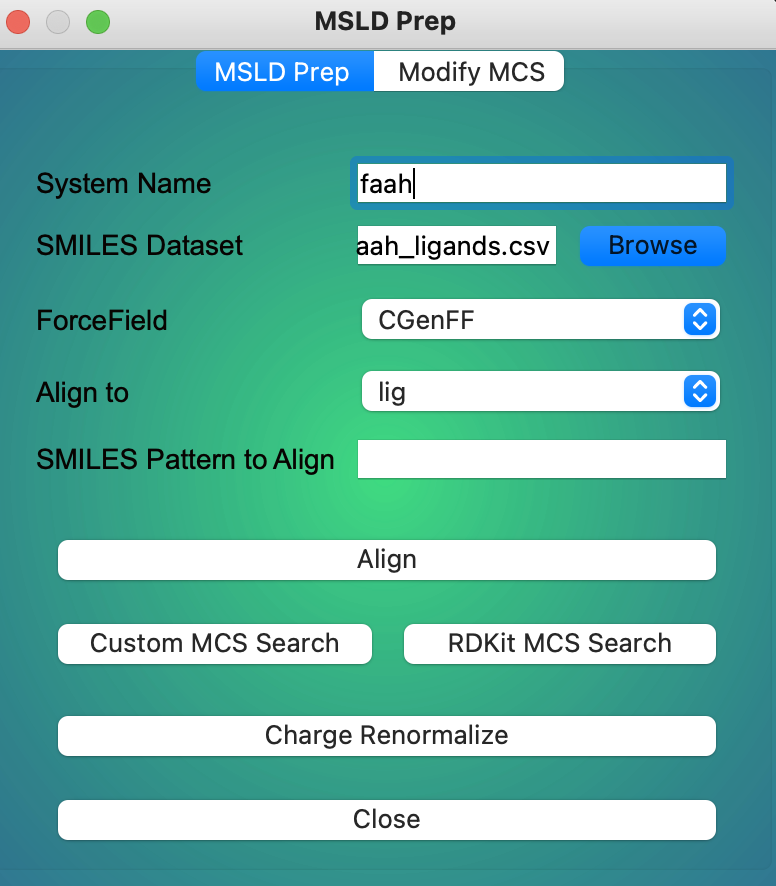

You should now have aligned molecules with their corresponding .mol2/.sdf files. Your PyMOL window should look like this:

In [ ]:
cmd.png(impath)
display.display(display.Image(impath))

Notice that all the molecules shown have the pyrimidine moiety in the middle. We need to visually inspect that this moiety is not flipped in some molecules. 

The orientation of the moiety will depend on your binding pocket. If the nitrogens in this moiety were flipped, we could have to manually need to tweak some torsions in pyMOL to have all of the molecules aligned before moving on. 


We also need to make sure that we have minimal clashes between the pocket and the ligands we just generated. 



In [ ]:
cmd.hide('lines','solvent')
cmd.show('lines','lig around 7')
cmd.enable('step2_solvator')
cmd.png(impath)

In [ ]:
display.display(display.Image(impath))

Because we are only going to use the first 6 molecules of our dataset for this example, we will leave out the lead compound for this tutorial since this allows us to explain the different sections of our code a bit more clearly.
#### It should be noted, however, that you usually want your lead compound to be included in the MSLD setup, since it's usually the only experimentally proven binder in your MSLD dataset in a prospective study.

In the plugin, all that is necessary to exclude the lead ligand is to disable it on the object window as so:

In [ ]:
cmd.disable('step2_solvator')
cmd.disable('lig')

Your object ribbon should look like this:

<div>
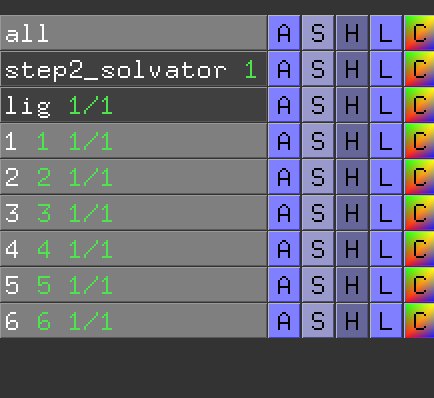
</div>

Proceed to Part III to show how we would do this on the command line.

## III. Setting up a Hybrid Topology System Using Charge Renormalization

Now that we have aligned molecules with a CHARMM compatible parameter/topology and a mol2 file, we can proceed in the plugin by clicking each button sequentially. If you have the ParamChem module loaded, then you can proceed as is. Otherwise, we will copy the parameter files before running the next set of buttons. 

In [ ]:
os.system('pwd;cp faah_ligs/*str .;ls')

In [ ]:
# Specify molecules you wish to do crn on
os.system('rm mol_list.txt')
os.system('for mol in `seq 1 6`; do echo $mol >> mol_list.txt; done')


# Specify system name in msld_py_prep.py
! sed 's/\"name\"/\"faah\"/g' ../msld-py-prep/msld_py_prep.py | tee ../msld-py-prep/msld_py_prep.py

In [ ]:
# # Run MCS Step
os.system('python ../msld-py-prep/msld_py_prep.py')
os.system('cat MCS_for_MSLD.txt')

After running this either through the `run vis_check.py` command or through the plugin after pressing the `MCS Search` button, you should get the following:


In [ ]:
# Visualize 
from rdkit.Chem import PyMol
v = PyMol.MolViewer()
v.server.do('run ../msld-py-prep/vis_check.py')
cmd.hide('labels','step2_solvator')

In [ ]:
cmd.hide('label','step2_solvator')
cmd.png(impath)
display.display(display.Image(impath))

Atoms shown as hard spheres are part of the `core` and the ones shown as stick are `substituents`, which we will be transforming alchemically throughout the MSLD simulation. In this case we only have one single site.

We sometimes might need a different MCS, which is why we want to modify the `MCS_for_MSLD.txt` file a little bit before proceeding. Some might prefer to have the whole ring be part of the substituents.  Atoms C017 and C021 in molecule 1 have been marked as part of the core. We might want to move them to the substituents.

To fix this in the plugin, go on edit mode and select this atom in this molecule (you can also select the corresponding atom in the other molecules). Once the atom is selected in edit mode, we can exclude it from the core by pressing the `Move` button and making the following specifications. We do this atom by atom (and only select the heavy atoms since hydrogens get moved with them.)

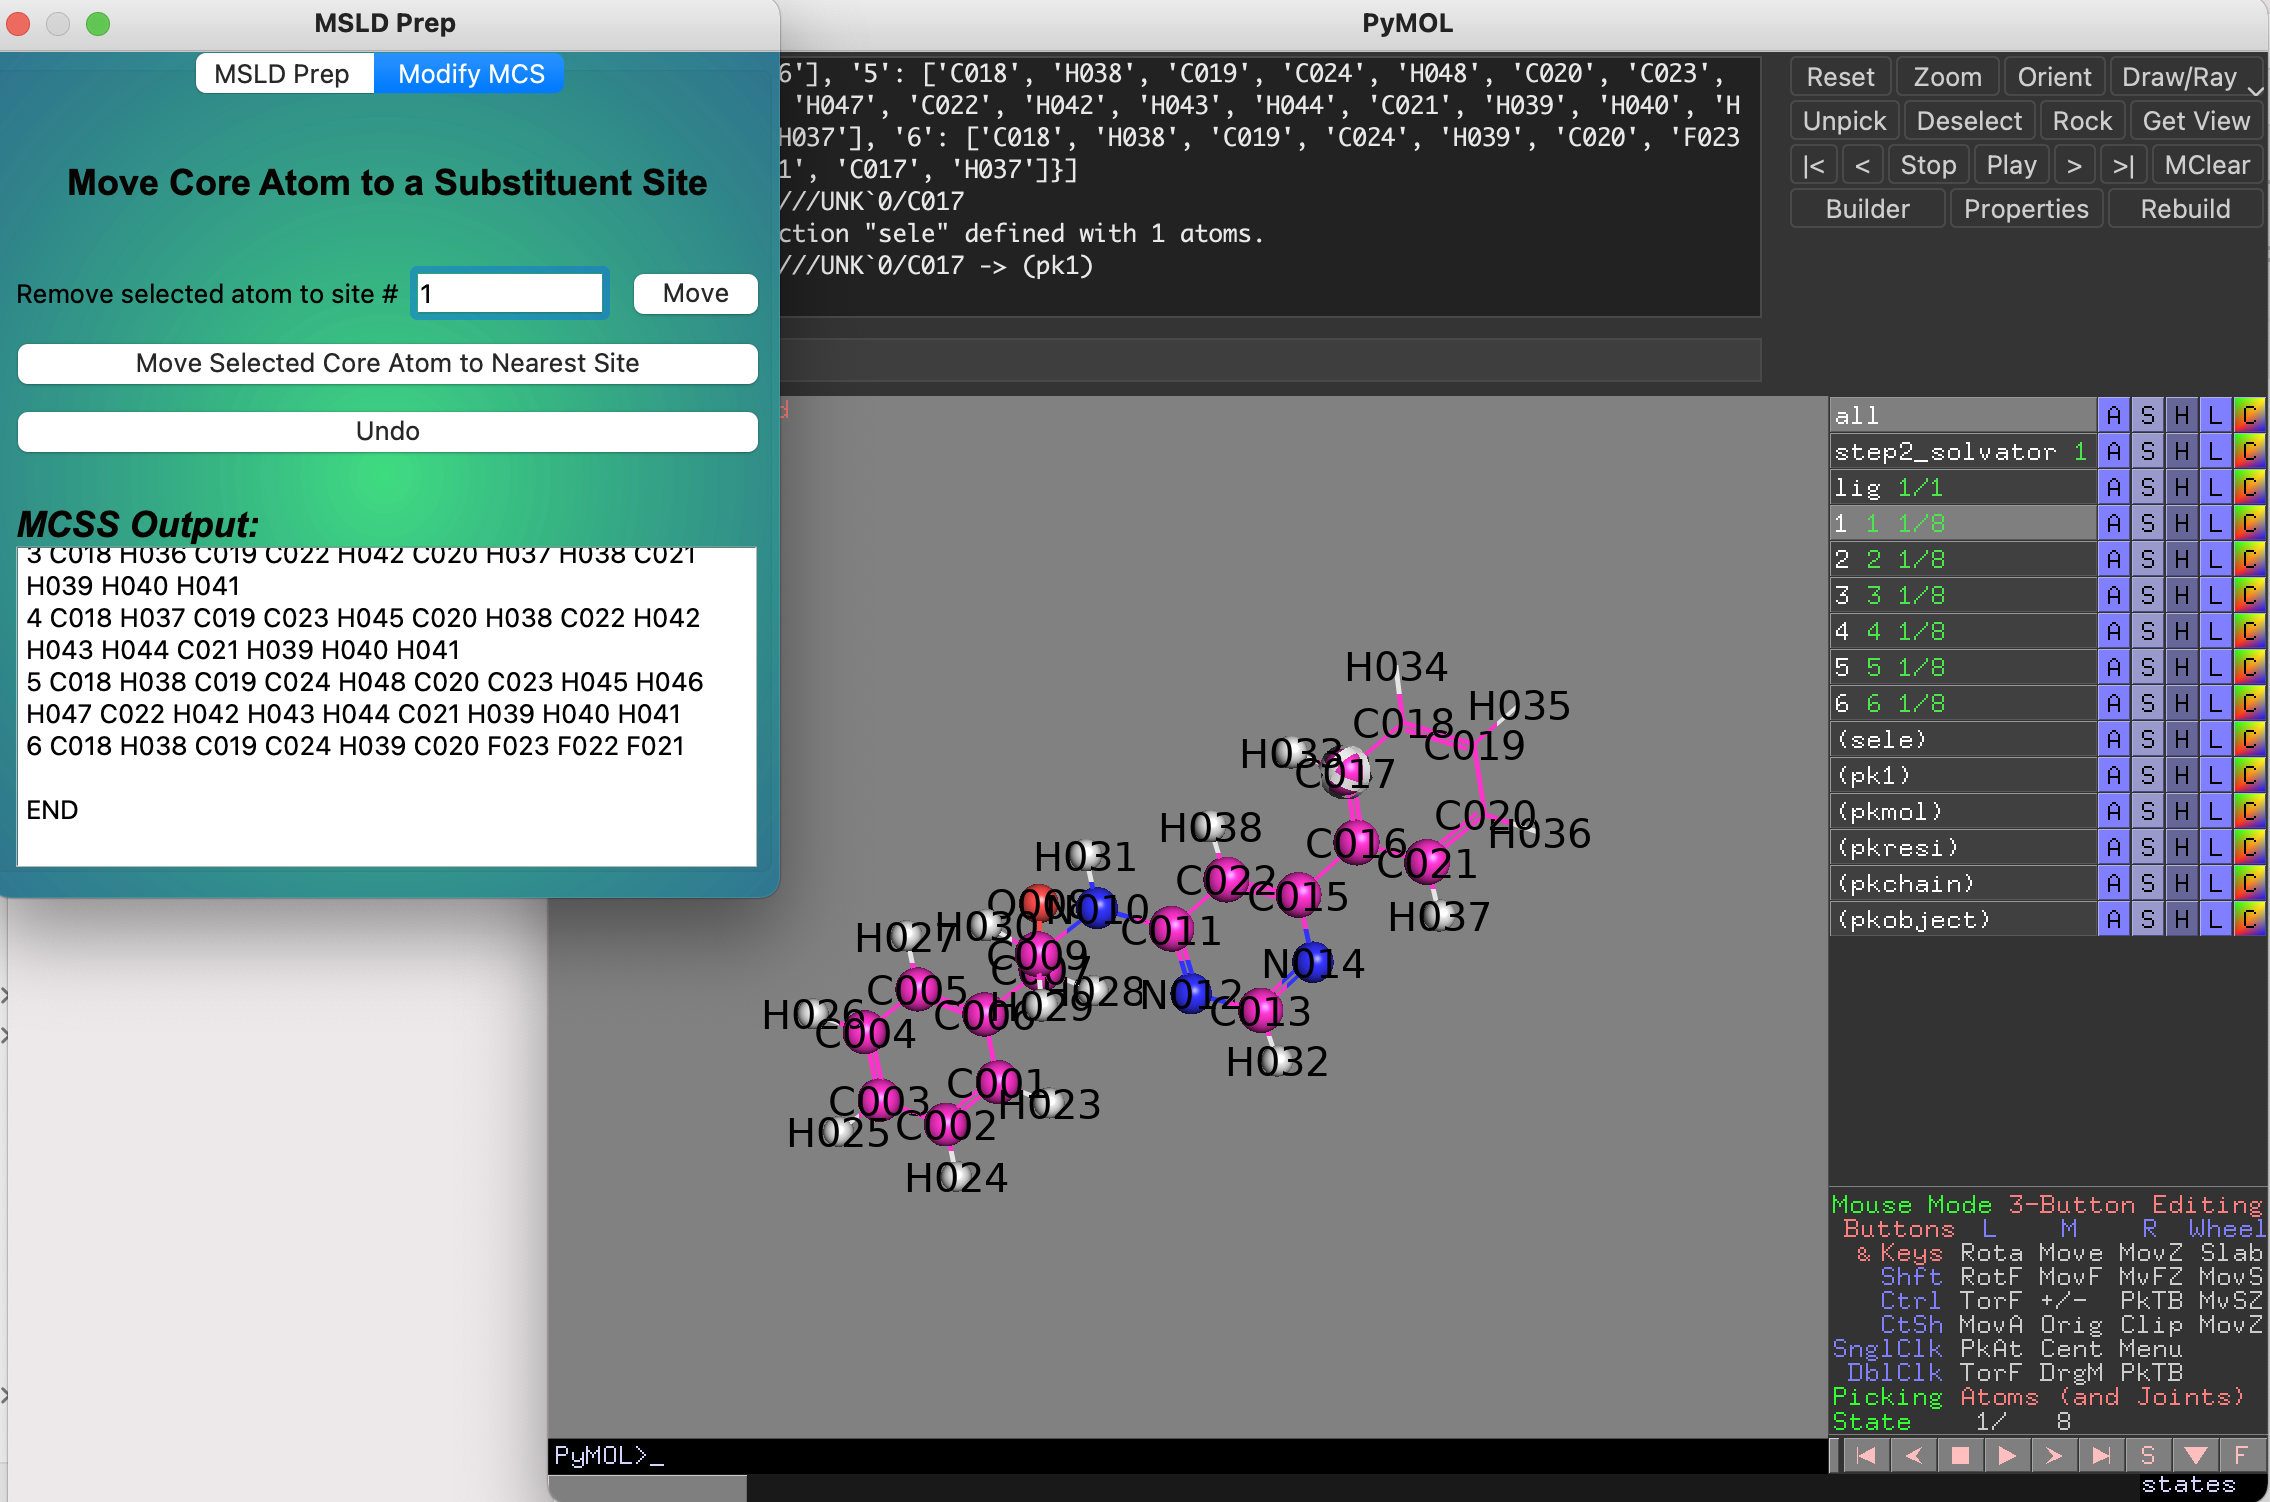

Since we only have one site of variation in this system, we have specified that we want to move it to site 1.

We are now ready to do the charge renormalization step, along with the fragmenting of the molecules in order to separate the core from the different fragments/substituents. This should output a directory called `build.jnk1`

In [ ]:
# Run charge renormalization Step 
# (Same command as for MCS Step but scripts identify that we have an `MCS_for_MSLD.txt` file)
! python ../msld-py-prep/msld_py_prep.py

### We need to pay close attention to the output to see if we have not changed the charges significantly.

From the charge renormalization paper cited at the beginning of this notebook, we can see that we start seeing changes in free energy predictions if we see an RMSD charge deviation from about 0.001e-
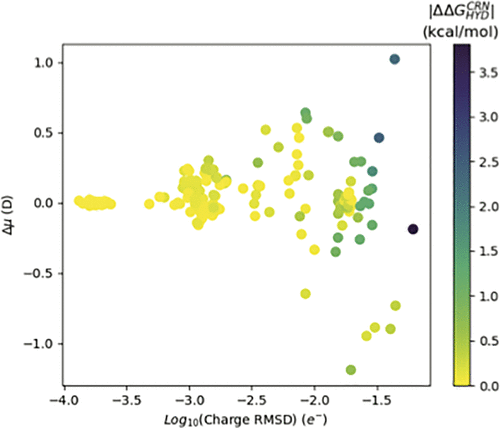

Now that we have made sure that we have not altered the charges as much, we can visualize the pdb files in the `build.faah` directory to make sure that we have a correct fragmentation.

In [ ]:
cmd.reinitialize()


for sub in range(6):
    cmd.load(f"build.faah/site1_sub{sub+1}_frag.pdb")
cmd.load('build.faah/core.pdb')
cmd.load('faah_charmmgui/step2_solvator.pdb')
cmd.center('core')
cmd.bg_color('white')
cmd.zoom('core',10)

cmd.png(impath)

In [ ]:
display.display(display.Image(impath))

### We are done! 
With the correct pdb, rtf, and prm files, as well as a CHARMM MSLD script (`jnk1.inp`) in the `build.jnk1` directory, we are ready for input into MSLD and pyCHARMM.

## pyCHARMM Import

In [ ]:
import os
import sys
import numpy as np

# These are a subset of the pycharmm modules that were installed when
# pycharmm was installed in your python environment
import pycharmm
import pycharmm.generate as gen
import pycharmm.ic as ic
import pycharmm.coor as coor
import pycharmm.energy as energy
import pycharmm.dynamics as dyn
import pycharmm.nbonds as nbonds
import pycharmm.minimize as minimize
import pycharmm.crystal as crystal
import pycharmm.image as image
import pycharmm.psf as psf
import pycharmm.read as read
import pycharmm.write as write
import pycharmm.settings as settings
import pycharmm.cons_harm as cons_harm
import pycharmm.cons_fix as cons_fix
import pycharmm.select as select
import pycharmm.shake as shake

from pycharmm.lib import charmm as libcharmm